NLP

Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import re
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

In [10]:
final_df = pd.read_csv('../files/reddit_cleaned.csv')
final_df.tail()

,title,text,subreddit,created_utc,clean_text
1689,I want to align my lifestyle with my values,I'm 23m and have become increasingly disenfran...,minimalism,1.743433e+09,23m become increasingly disenfranchised societ...
1690,Minimalist wardrobe for men?,I am in college and looking to start upgrading...,minimalism,1.743442e+09,college looking start upgrading high school cl...
1691,Why do we feel guilty about decluttering?,Isnt it stupid? I am going through things in m...,minimalism,1.743443e+09,isnt stupid going thing mind desperately want ...
1692,What are your essentials and then what are you...,I live in a four season state what are your gu...,minimalism,1.743447e+09,live four season state guy essential living fo...
1693,Dishes & food storage,Y'all have any ideas regarding dishes and food...,minimalism,1.743454e+09,idea regarding dish food storage part wonder u...


map the Target! declutter = 0 and Minimalism = 1

In [11]:
final_df['subreddit_label'] = final_df['subreddit'].map({'declutter': 0, 'minimalism': 1})

In [12]:
final_df.tail(3)

,title,text,subreddit,created_utc,clean_text,subreddit_label
1691,Why do we feel guilty about decluttering?,Isnt it stupid? I am going through things in m...,minimalism,1.743443e+09,isnt stupid going thing mind desperately want ...,1
1692,What are your essentials and then what are you...,I live in a four season state what are your gu...,minimalism,1.743447e+09,live four season state guy essential living fo...,1
1693,Dishes & food storage,Y'all have any ideas regarding dishes and food...,minimalism,1.743454e+09,idea regarding dish food storage part wonder u...,1


In [13]:
final_df.isna().sum()

title              0
text               0
subreddit          0
created_utc        0
clean_text         2
subreddit_label    0
dtype: int64

There are 3 empty values in each clean_text and clean_title, this could be due to removing the stop words during preprocessing. Since only 3 cells are affected, I am going to drop them which will still leave me with 1997 data to work with

In [14]:
final_df.dropna(inplace = True)

In [15]:
final_df.shape

(1692, 6)

Assign our X and y, which will be our cleaned text used to find out our subreddit

In [16]:
X = final_df['clean_text']
y = final_df['subreddit_label']

In [17]:
# Split the data into the training and testing sets.
#stratify because we want the class distribution continued
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                   test_size = 0.2,
                                                   stratify = y)

In [18]:

#https://docs.python.org/3/library/re.html
def clean_text_refined(text):
    if isinstance(text, str):
        
        # Remove numbers,non-alphabeti, repeated characters, and alphanumeric words,
        text = re.sub(r'\b\d+\b', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'(.)\1{2,}', '', text)  
        text = re.sub(r'\b\w*\d\w*\b', '', text)
        text = re.sub(r'_', ' ', text)

    return text


In [19]:
X_train_clean = X_train.apply(clean_text_refined)
X_test_clean = X_test.apply(clean_text_refined)

In [20]:
tvec = TfidfVectorizer(stop_words = "english",
                       min_df=2,
                      max_df=0.6) 
#remove terms that appear less than 2 times, and word that appear in 60% or more

In [21]:
#fitting on training data to prevent leaking
X_train_tvec = tvec.fit_transform(X_train_clean)

In [22]:

#transforming
X_test_tvec = tvec.transform(X_test_clean)
#tfid can give neg values; so we will replace it with 0
X_train_tvec[X_train_tvec < 0] = 0
X_test_tvec[X_test_tvec < 0] = 0

X_train_tvec_df = pd.DataFrame(X_train_tvec.toarray(), columns=tvec.get_feature_names_out())
X_test_tvec_df = pd.DataFrame(X_test_tvec.toarray(), columns=tvec.get_feature_names_out())

print(X_train_tvec_df.head())
print(X_test_tvec_df.head())

   abandoned  abiding  ability      able  abroad  absolute  absolutely  \
0        0.0      0.0      0.0  0.000000     0.0       0.0         0.0   
1        0.0      0.0      0.0  0.000000     0.0       0.0         0.0   
2        0.0      0.0      0.0  0.000000     0.0       0.0         0.0   
3        0.0      0.0      0.0  0.033408     0.0       0.0         0.0   
4        0.0      0.0      0.0  0.000000     0.0       0.0         0.0   

   absurd  absurdity  abundance  ...  yummy  zara  zasio  zealand  zen  \
0     0.0        0.0        0.0  ...    0.0   0.0    0.0      0.0  0.0   
1     0.0        0.0        0.0  ...    0.0   0.0    0.0      0.0  0.0   
2     0.0        0.0        0.0  ...    0.0   0.0    0.0      0.0  0.0   
3     0.0        0.0        0.0  ...    0.0   0.0    0.0      0.0  0.0   
4     0.0        0.0        0.0  ...    0.0   0.0    0.0      0.0  0.0   

       zero  zip  zipper  zone  zoom  
0  0.159747  0.0     0.0   0.0   0.0  
1  0.000000  0.0     0.0   0.0  

## Modeling!

Creating a baseline model, to compare my models with

In [30]:
y_train_counts = y_train.value_counts()
print(y_train_counts)
majority_class = y_train_counts.idxmax()
baseline_accuracy = (y_train == majority_class).mean()
print(f"Baseline Accuracy: {baseline_accuracy}")


subreddit_label
0    799
1    554
Name: count, dtype: int64
Baseline Accuracy: 0.590539541759054


If I were to predict 0, or "declutter" reddit post for al of my data. I wold be correct 59.05% of the time.
In any model I build, I would like a value greater than that.

## Model 1

a scaled LogisticRegression model with GridSearchCV

In [31]:
# Create pipeline with scaling
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

# Fit the pipeline
pipe.fit(X_train_tvec_df, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('lr', LogisticRegression())])

In [32]:
param_grid = {
    'lr__C': [0.1, 1, 10],  # c value
}

# set up GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=5)

# fit in training data
grid_search.fit(X_train_tvec_df, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': [0.1, 1, 10]})

In [33]:
best_params = grid_search.best_params_
print(f"Best Hyperparameter: {best_params}")

Best Hyperparameter: {'lr__C': 0.1}


In [34]:
# bet model
best_model = grid_search.best_estimator_

# coeffs
coefs = best_model.named_steps['lr'].coef_[0]


features = X_train_tvec_df.columns
coefs_df = pd.DataFrame({'Feature': features, 'Coefficient': coefs})
coefs_df = coefs_df.sort_values('Coefficient', ascending=False)

print("\nTop Features for Minimalism subreddit:")
print(coefs_df.head(10))
print("\nTop Features for Declutter subreddit:")
print(coefs_df.tail(10))


Top Features for Minimalism subreddit:
             Feature  Coefficient
2808      minimalism     0.274478
2809      minimalist     0.273265
883          content     0.153437
2528            life     0.143172
4814         unknown     0.138630
1623              fb     0.126635
2538         lighter     0.125566
3606  recommendation     0.116059
2810    minimalistic     0.114925
1775         freeing     0.111538

Top Features for Declutter subreddit:
           Feature  Coefficient
5002          week    -0.127201
2190         imgur    -0.134830
4703         trash    -0.140383
1045           day    -0.154935
1987          hand    -0.164136
700          clean    -0.167267
2355          item    -0.190829
1068     declutter    -0.192737
1071  decluttering    -0.206394
4564          text    -0.320281


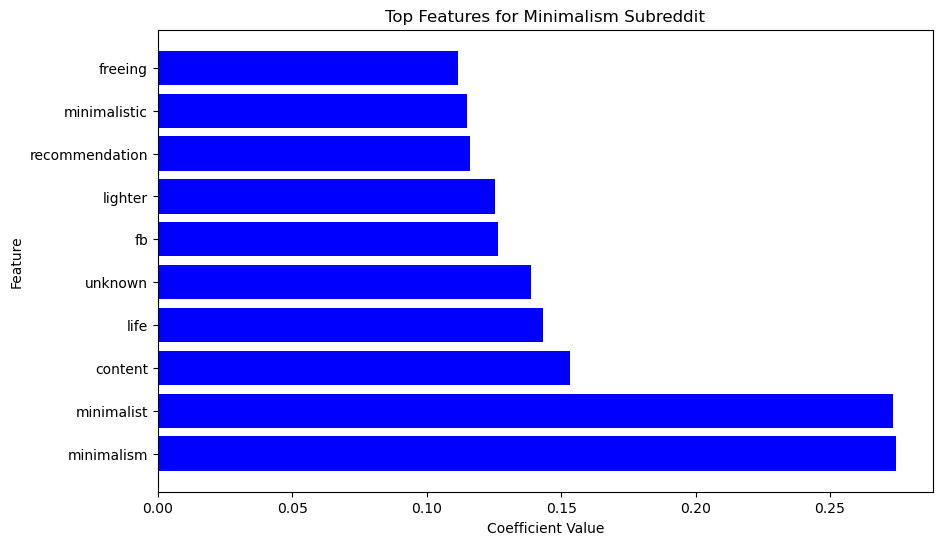

In [35]:
plt.figure(figsize=(10, 6))
plt.barh(coefs_df.head(10)['Feature'], coefs_df.head(10)['Coefficient'], color='blue')  # Blue for Minimalism
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top Features for Minimalism Subreddit');

The coefficient for minimalist is 0.265295; i.e. that posts containing the word "minimalist" are more likely to belong to the Minimalism subreddit.
e  ^ 0.265295 ≈1.303
(1.303−1)×100≈30.3% 

each one-unit increase in the frequency of the word "minimalist," the odds of the post belonging to the Minimalism subreddit increase by 30.3%

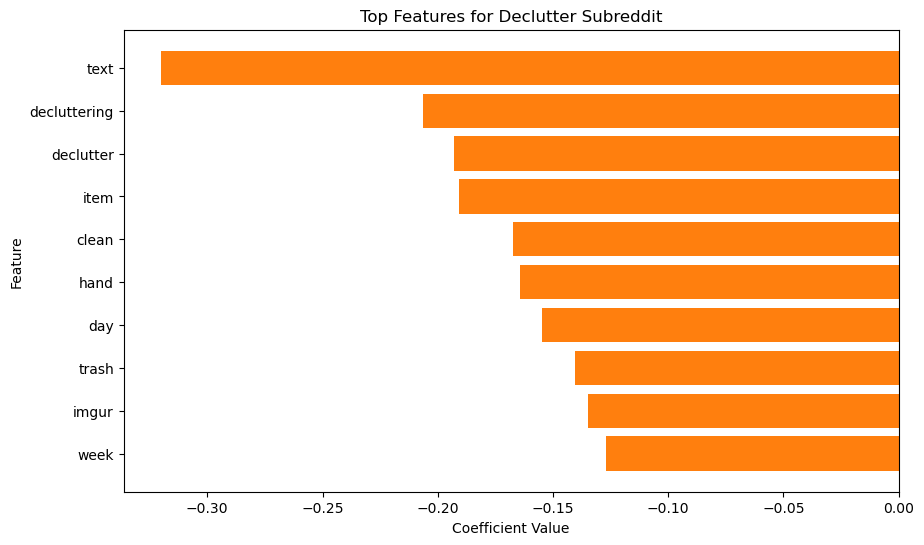

In [36]:
plt.figure(figsize=(10, 6))
plt.barh(coefs_df.tail(10)['Feature'], coefs_df.tail(10)['Coefficient'], color='#ff7f0e')  # Orange for Declutter
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top Features for Declutter Subreddit');

similar as above this means that the odds of the post belonging to the Declutter subreddit increase by 30.2% for each one-unit increase in the frequency of the word "text."

In [38]:
y_pred = best_model.predict(X_test_tvec_df)
cm = confusion_matrix(y_test, y_pred)

# Extract FP and FN from confusion matrix
tn, fp, fn, tp = cm.ravel()

print(f"False Positive (FP): {fp}")
print(f"False Negative (FN): {fn}")
print(f"True Negative (TN): {tn}")
print(f"True Positive (TP): {tp}")

False Positive (FP): 31
False Negative (FN): 51
True Negative (TN): 169
True Positive (TP): 88


In [39]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
print(" Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

 Logistic Regression Accuracy: 0.7581120943952803
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       200
           1       0.74      0.63      0.68       139

    accuracy                           0.76       339
   macro avg       0.75      0.74      0.74       339
weighted avg       0.76      0.76      0.75       339



My first model accuracy is 75.81% i.e. my model correctly predicted the subreddit that it belongs to 77% of the time. 

precision: 
When the model predicted Declutter, it was correct 77% of the time i.e. 13% of time it belonged to minimalism(False Positives).
When the model predicted Minimalism, it was correct 74% of the time i.e. 26% of time it belonged to declutter(False Positives)


recall: 
Out of all the declutter post, the model predicted this outcome correctly 74% of the time i.e. 23% of the time it was predicted as minimalism (False Negative)
Out of all the minimalism post, the model predicted this outcome correctly 63% of the time i.e. 37% of the time it was predicted as declutter (False Negative)

f1- socre:
It is mean of precision and recall. 


## Model 2

In [40]:
#logistic regression with hyperprarameter tuning
#https://scikit-learn.org/stable/modules/grid_search.html
#https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline

Start by creating a pipeline, The pipeline can be used as any other estimator and avoids leaking the test set into the train set

In [41]:
pipe = Pipeline([
    ('nb', MultinomialNB())
])
param_grid = {
    'nb__alpha': [0.1, 0.5, 1, 2], #finding smoothing alpha 
}


In [42]:
#GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(pipe, param_grid, cv=5)

# Perform Cross-validation and fit the grid search
grid_search.fit(X_train_tvec_df, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('nb', MultinomialNB())]),
             param_grid={'nb__alpha': [0.1, 0.5, 1, 2]})

In [43]:
# best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Hyperparameter: {best_params}")
print(f"Best Cross-validation Score: {best_score}")

Best Hyperparameter: {'nb__alpha': 0.1}
Best Cross-validation Score: 0.7953122864561979


In [44]:
# best model after hyperparameter tuning
best_model = grid_search.best_estimator_

# fiting the best on trainign
best_model.fit(X_train_tvec_df, y_train)

Pipeline(steps=[('nb', MultinomialNB(alpha=0.1))])

In [47]:

# Test score with the best model
test_score = best_model.score(X_test_tvec_df, y_test)
print("Test score: ", test_score)

Test score:  0.8377581120943953


In [46]:
y_pred = best_model.predict(X_test_tvec_df)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.81      0.95      0.87       200
           1       0.91      0.67      0.77       139

    accuracy                           0.84       339
   macro avg       0.86      0.81      0.82       339
weighted avg       0.85      0.84      0.83       339



My model accuracy is 83.78%

precision: When the model predicted Declutter, it was correct 81% of the time i.e. 19% of time it belonged to minimalism(False Positives). When the model predicted Minimalism, it was correct 91% of the time i.e. 9% of time it belonged to declutter(False Positives)

recall: Out of all the declutter post, the model predicted this outcome correctly 95% of the time i.e. 5% of the time it was predicted as minimalism (False Negative) Out of all the minimalism post, the model predicted this outcome correctly 67% of the time i.e. 33% of the time it was predicted as declutter (False Negative)

f1- socre: It is mean of precision and recall.


